# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Utah/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Utah/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.zip')
dfs = pd.read_csv('ProcessedInputData/wr_sites.zip')

C:\Users\rjame\AppData\Local\Temp\ipykernel_16400\3773195327.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.read_csv('ProcessedInputData/wr_sites.zip')


In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'RegulatoryOverlayTypeCV', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['RegulatoryOverlayTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Water Right Areas' 'Groundwater Policy Management'
 'Basins Closed to New Appropriations'
 'Areas Open to Limited Appropriation']
['Surface Water and Groundwater' 'Groundwater']
120


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,RegulatoryOverlayTypeCV,WaterSourceTypeCV
0,UTre_RUut_01,4326,WaDE Blank,ut_01,NaN,WaDE Blank,5/31/2022,UT,POLYGON ((-109.05137143299999 39.4977101130000...,UTre_ROutr1_01,Water Right Areas,Surface Water and Groundwater


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Underground' 'Surface' 'Point of Return' 'Spring' 'Rediversion'
 'Point to Point' 'Abandonded Well' 'Drain' 'WaDE Blank']
342533


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,UTwr_SPOD864475642,NaN,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,40.42486,-112.42675,NaN,NaN,POD,Underground Water Well,POD864475642,NaN,WaDE Blank,UT,NaN,UTwr_WSwadeID3,Underground


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Water Right Areas" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['RegulatoryOverlayTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

50
['Surface Water and Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,RegulatoryOverlayTypeCV,WaterSourceTypeCV
0,UTre_RUut_01,4326,WaDE Blank,ut_01,NaN,WaDE Blank,5/31/2022,UT,POLYGON ((-109.05137143299999 39.4977101130000...,UTre_ROutr1_01,Water Right Areas,Surface Water and Groundwater


<GeoAxes: >

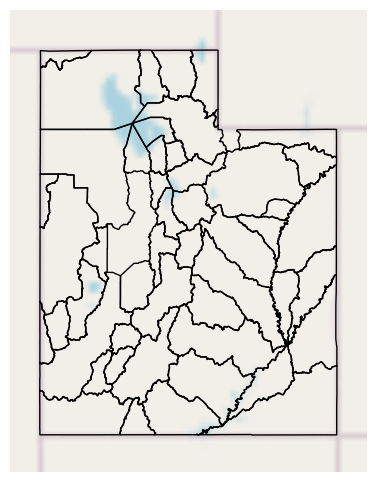

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
# nameOfWaterSourceTypeCV= "add name here" # change here for WaterSourceTypeCV of interest
# dfs1 = dfs1[dfs1['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

220029
['Underground' 'Surface' 'Point of Return' 'Spring' 'Rediversion'
 'Point to Point' 'Abandonded Well' 'Drain']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,UTwr_SPOD864475642,NaN,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,40.42486,-112.42675,NaN,NaN,POD,Underground Water Well,POD864475642,NaN,WaDE Blank,UT,NaN,UTwr_WSwadeID3,Underground


<GeoAxes: >

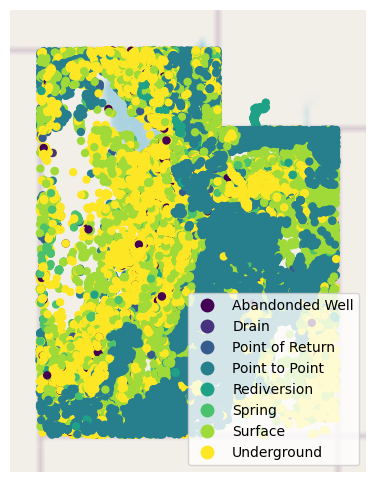

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


213255


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
2,UTwr_SPOD864475654,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.19789,-113.74142,,,POD,Underground Water Well,POD864475654,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-113.74142 38.19789),5,UTre_RUut_14,UTre_ROutr1_14
3,UTwr_SPOD864475655,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.19789,-113.74142,,,POD,Underground Water Well,POD864475655,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-113.74142 38.19789),5,UTre_RUut_14,UTre_ROutr1_14
4,UTwr_SPOD864475656,,UTwr_WSwadeID18808,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.54786,-113.85914,,,POD,Beers Tunnel Spring,POD864475656,,WaDE Blank,UT,,UTwr_WSwadeID18808,Surface,POINT (-113.85914 38.54786),5,UTre_RUut_14,UTre_ROutr1_14
5,UTwr_SPOD864475657,,UTwr_WSwadeID19259,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.23136,-113.80716,,,POD,Holtz Creek,POD864475657,,WaDE Blank,UT,,UTwr_WSwadeID19259,Surface,POINT (-113.80716 38.23136),5,UTre_RUut_14,UTre_ROutr1_14
6,UTwr_SPOD864475658,,UTwr_WSwadeID19259,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.23243,-113.80263,,,POD,Holtz Creek,POD864475658,,WaDE Blank,UT,,UTwr_WSwadeID19259,Surface,POINT (-113.80263 38.23243),5,UTre_RUut_14,UTre_ROutr1_14


<GeoAxes: >

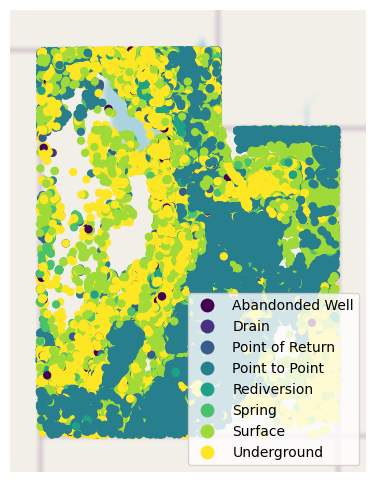

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
2,UTwr_SPOD864475654,UTre_ROutr1_14,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.19789,-113.74142,,,POD,Underground Water Well,POD864475654,,WaDE Blank,UT,


#### Regulatory Area Data #2

In [13]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru2 = dfru.copy()
nameOfReportingUnitTypeVar = "Groundwater Policy Management" # change here for ReportingUnitTypeCV of interest
dfru2 = dfru2[dfru2['RegulatoryOverlayTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru2))
print(dfru2['WaterSourceTypeCV'].unique())
dfru2.head(1)

60
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,RegulatoryOverlayTypeCV,WaterSourceTypeCV
1,UTre_RUut_01,4326,WaDE Blank,ut_01,NaN,WaDE Blank,5/31/2022,UT,POLYGON ((-109.05137143299999 39.4977101130000...,UTre_ROutr2_01,Groundwater Policy Management,Groundwater


<GeoAxes: >

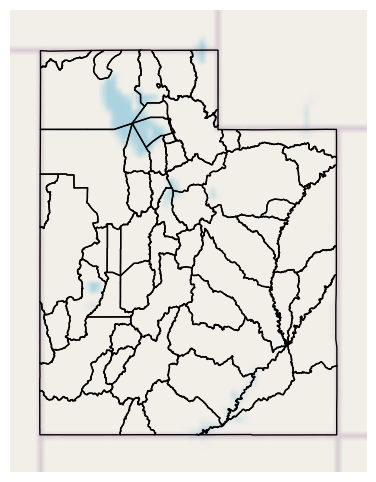

In [14]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru2 = dfru2[dfru2['Geometry'] != ""].reset_index(drop=True)
dfru2['Geometry'] = gpd.GeoSeries.from_wkt(dfru2['Geometry'], crs="EPSG:4326")
gdfru2 = gpd.GeoDataFrame(dfru2, geometry=dfru2['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru2, ax=ax)

In [15]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs2 = dfs.copy()
nameOfWaterSourceTypeCVList = ['Abandonded Well', 'Underground', 'Spring' ] # change here for WaterSourceTypeCV of interest
dfs2 = dfs2[dfs2['WaterSourceTypeCV'].isin(nameOfWaterSourceTypeCVList)]
dfs2 = dfs2[dfs2['PODorPOUSite'] == 'POD']
print(len(dfs2))
print(dfs2['WaterSourceTypeCV'].unique())
dfs2.head(1)

109044
['Underground' 'Spring' 'Abandonded Well']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,UTwr_SPOD864475642,NaN,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,40.42486,-112.42675,NaN,NaN,POD,Underground Water Well,POD864475642,NaN,WaDE Blank,UT,NaN,UTwr_WSwadeID3,Underground


<GeoAxes: >

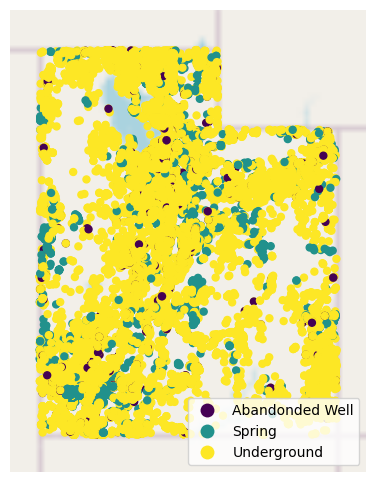

In [16]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs2 = gpd.GeoDataFrame(dfs2, geometry=gpd.points_from_xy(dfs2.Longitude.astype(float), dfs2.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs2, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [17]:
# Select sites within polygon.
gdfs2_ru2 = gpd.sjoin(left_df=gdfs2, right_df=gdfru2[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs2_ru2))
gdfs2_ru2.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


109037


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,UTwr_SPOD864475642,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.42486,-112.42675,,,POD,Underground Water Well,POD864475642,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-112.42675 40.42486),8,UTre_RUut_15b,UTre_ROutr2_15b
1,UTwr_SPOD864475643,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.33884,-112.44543,,,POD,Underground Water Well,POD864475643,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-112.44543 40.33884),8,UTre_RUut_15b,UTre_ROutr2_15b
341,UTwr_SPOD864476073,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.41707,-112.38463,,,POD,Underground Water Well,POD864476073,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-112.38463 40.41707),8,UTre_RUut_15b,UTre_ROutr2_15b
1185,UTwr_SPOD864477349,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.33627,-112.45930,,,POD,Underground Water Well,POD864477349,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-112.45930 40.33627),8,UTre_RUut_15b,UTre_ROutr2_15b
1186,UTwr_SPOD864477350,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.14698,-112.44986,,,POD,Underground Water Well,POD864477350,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-112.44986 40.14698),8,UTre_RUut_15b,UTre_ROutr2_15b


<GeoAxes: >

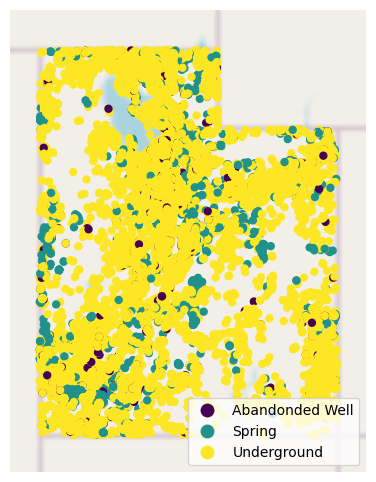

In [18]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs2_ru2, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [19]:
# set RegulatoryOverlayUUIDs
gdfs2_ru2['RegulatoryOverlayUUIDs'] = gdfs2_ru2['RegulatoryOverlayUUID']
gdfs2_ru2 = gdfs2_ru2.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs2_ru2.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,UTwr_SPOD864475642,UTre_ROutr2_15b,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.42486,-112.42675,,,POD,Underground Water Well,POD864475642,,WaDE Blank,UT,


#### Regulatory Area Data #3

In [20]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru3 = dfru.copy()
nameOfReportingUnitTypeVar = "Basins Closed to New Appropriations" # change here for ReportingUnitTypeCV of interest
dfru3 = dfru3[dfru3['RegulatoryOverlayTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru3))
print(dfru3['WaterSourceTypeCV'].unique())
dfru3.head(1)

4
['Surface Water and Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,RegulatoryOverlayTypeCV,WaterSourceTypeCV
110,UTre_RUutr3_21,4326,WaDE Blank,utr3_21,NaN,WaDE Blank,5/31/2022,UT,"POLYGON ((-112.169039726 41.15293997600003, -1...",UTre_ROutr3_21,Basins Closed to New Appropriations,Surface Water and Groundwater


<GeoAxes: >

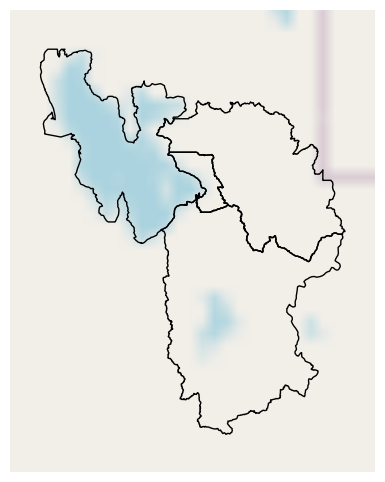

In [21]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru3 = dfru3[dfru3['Geometry'] != ""].reset_index(drop=True)
dfru3['Geometry'] = gpd.GeoSeries.from_wkt(dfru3['Geometry'], crs="EPSG:4326")
gdfru3 = gpd.GeoDataFrame(dfru3, geometry=dfru3['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru3, ax=ax)

In [22]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs3 = dfs.copy()
# nameOfWaterSourceTypeCV= "add name here" # change here for WaterSourceTypeCV of interest
# dfs3 = dfs3[dfs3['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs3 = dfs3[dfs3['PODorPOUSite'] == 'POD']
print(len(dfs3))
print(dfs3['WaterSourceTypeCV'].unique())
dfs3.head(1)

220029
['Underground' 'Surface' 'Point of Return' 'Spring' 'Rediversion'
 'Point to Point' 'Abandonded Well' 'Drain']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,UTwr_SPOD864475642,NaN,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,40.42486,-112.42675,NaN,NaN,POD,Underground Water Well,POD864475642,NaN,WaDE Blank,UT,NaN,UTwr_WSwadeID3,Underground


<GeoAxes: >

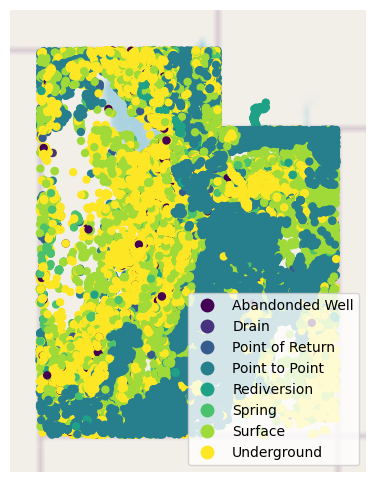

In [23]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs3 = gpd.GeoDataFrame(dfs3, geometry=gpd.points_from_xy(dfs3.Longitude.astype(float), dfs3.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs3, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [24]:
# Select sites within polygon.
gdfs3_ru3 = gpd.sjoin(left_df=gdfs3, right_df=gdfru3[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs3_ru3))
gdfs3_ru3.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


55036


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
91,UTwr_SPOD864475774,,UTwr_WSwadeID8200,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.42647,-111.69843,,,POD,Burnt Spring #2,POD864475774,,WaDE Blank,UT,,UTwr_WSwadeID8200,Point to Point,POINT (-111.69843 40.42647),3,UTre_RUutr3_53,UTre_ROutr3_53
92,UTwr_SPOD864475775,,UTwr_WSwadeID56,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,39.78949,-111.55399,,,POD,Unnamed Spring,POD864475775,,WaDE Blank,UT,,UTwr_WSwadeID56,Point to Point,POINT (-111.55399 39.78949),3,UTre_RUutr3_53,UTre_ROutr3_53
93,UTwr_SPOD864475776,,UTwr_WSwadeID56,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,39.78582,-111.55397,,,POD,Unnamed Spring,POD864475776,,WaDE Blank,UT,,UTwr_WSwadeID56,Point to Point,POINT (-111.55397 39.78582),3,UTre_RUutr3_53,UTre_ROutr3_53
94,UTwr_SPOD864475777,,UTwr_WSwadeID8369,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,39.77420,-111.58502,,,POD,Left Fork Spencer Creek,POD864475777,,WaDE Blank,UT,,UTwr_WSwadeID8369,Point to Point,POINT (-111.58502 39.77420),3,UTre_RUutr3_53,UTre_ROutr3_53
95,UTwr_SPOD864475778,,UTwr_WSwadeID8375,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,39.79243,-111.57410,,,POD,Colorado Homestead Beaver Springs,POD864475778,,WaDE Blank,UT,,UTwr_WSwadeID8375,Point to Point,POINT (-111.57410 39.79243),3,UTre_RUutr3_53,UTre_ROutr3_53


<GeoAxes: >

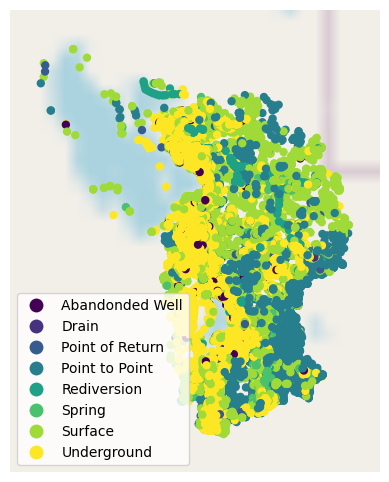

In [25]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs3_ru3, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [26]:
# set RegulatoryOverlayUUIDs
gdfs3_ru3['RegulatoryOverlayUUIDs'] = gdfs3_ru3['RegulatoryOverlayUUID']
gdfs3_ru3 = gdfs3_ru3.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs3_ru3.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
91,UTwr_SPOD864475774,UTre_ROutr3_53,UTwr_WSwadeID8200,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.42647,-111.69843,,,POD,Burnt Spring #2,POD864475774,,WaDE Blank,UT,


#### Regulatory Area Data #4

In [27]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru4 = dfru.copy()
nameOfReportingUnitTypeVar = "Areas Open to Limited Appropriation" # change here for ReportingUnitTypeCV of interest
dfru4 = dfru4[dfru4['RegulatoryOverlayTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru4))
print(dfru4['WaterSourceTypeCV'].unique())
dfru4.head(1)

6
['Surface Water and Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,RegulatoryOverlayTypeCV,WaterSourceTypeCV
114,UTre_RUutr4_21,4326,WaDE Blank,utr4_21,NaN,WaDE Blank,5/31/2022,UT,POLYGON ((-111.04673263199999 41.2516295060000...,UTre_ROutr4_21,Areas Open to Limited Appropriation,Surface Water and Groundwater


<GeoAxes: >

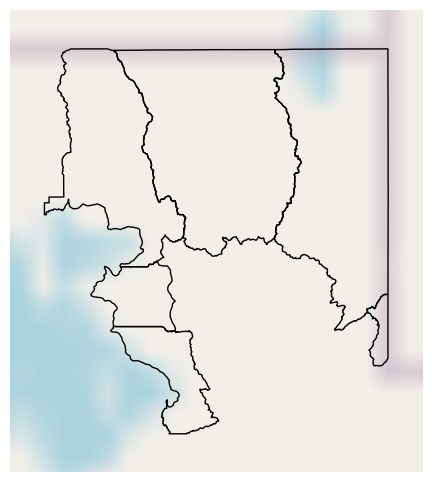

In [28]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru4 = dfru4[dfru4['Geometry'] != ""].reset_index(drop=True)
dfru4['Geometry'] = gpd.GeoSeries.from_wkt(dfru4['Geometry'], crs="EPSG:4326")
gdfru4 = gpd.GeoDataFrame(dfru4, geometry=dfru4['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru4, ax=ax)

In [29]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs4 = dfs.copy()
# nameOfWaterSourceTypeCV= "add name here" # change here for WaterSourceTypeCV of interest
# dfs2 = dfs2[dfs2['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs4 = dfs4[dfs4['PODorPOUSite'] == 'POD']
print(len(dfs4))
print(dfs4['WaterSourceTypeCV'].unique())
dfs4.head(1)

220029
['Underground' 'Surface' 'Point of Return' 'Spring' 'Rediversion'
 'Point to Point' 'Abandonded Well' 'Drain']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,UTwr_SPOD864475642,NaN,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,40.42486,-112.42675,NaN,NaN,POD,Underground Water Well,POD864475642,NaN,WaDE Blank,UT,NaN,UTwr_WSwadeID3,Underground


<GeoAxes: >

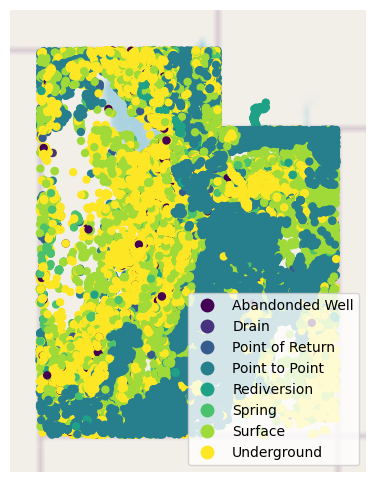

In [30]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs4 = gpd.GeoDataFrame(dfs4, geometry=gpd.points_from_xy(dfs4.Longitude.astype(float), dfs4.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs4, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [31]:
# Select sites within polygon.
gdfs4_ru4 = gpd.sjoin(left_df=gdfs4, right_df=gdfru4[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs4_ru4))
gdfs4_ru4.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


33702


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
33,UTwr_SPOD864475699,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.95235,-111.39301,,,POD,Underground Water Well,POD864475699,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-111.39301 41.95235),1,UTre_RUutr4_23,UTre_ROutr4_23
34,UTwr_SPOD864475700,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.49131,-111.11858,,,POD,Underground Water Well,POD864475700,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-111.11858 41.49131),1,UTre_RUutr4_23,UTre_ROutr4_23
35,UTwr_SPOD864475701,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.49809,-111.14781,,,POD,Underground Water Well,POD864475701,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-111.14781 41.49809),1,UTre_RUutr4_23,UTre_ROutr4_23
36,UTwr_SPOD864475702,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.65005,-111.20917,,,POD,Underground Water Well,POD864475702,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground,POINT (-111.20917 41.65005),1,UTre_RUutr4_23,UTre_ROutr4_23
37,UTwr_SPOD864475703,,UTwr_WSwadeID24666,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.99038,-111.41229,,,POD,Cottonwood Buelah Springs,POD864475703,,WaDE Blank,UT,,UTwr_WSwadeID24666,Surface,POINT (-111.41229 41.99038),1,UTre_RUutr4_23,UTre_ROutr4_23


<GeoAxes: >

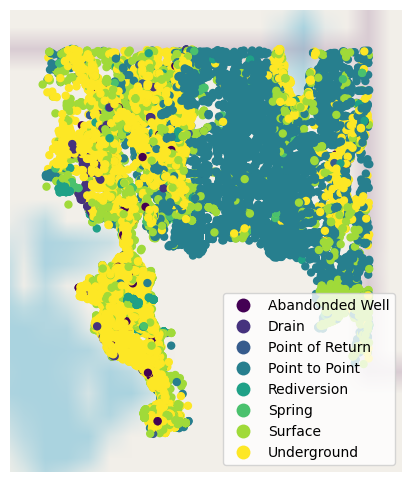

In [32]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs4_ru4, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [33]:
# set RegulatoryOverlayUUIDs
gdfs4_ru4['RegulatoryOverlayUUIDs'] = gdfs4_ru4['RegulatoryOverlayUUID']
gdfs4_ru4 = gdfs4_ru4.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs4_ru4.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
33,UTwr_SPOD864475699,UTre_ROutr4_23,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.95235,-111.39301,,,POD,Underground Water Well,POD864475699,,WaDE Blank,UT,


## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [34]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1, gdfs2_ru2, gdfs3_ru3] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

276899


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,UTwr_SPOD864475642,UTre_ROutr2_15b,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.42486152200007,-112.426748144,,,POD,Underground Water Well,POD864475642,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground


# Inspect Output Data & Export

In [35]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276899 entries, 0 to 276898
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                276899 non-null  object
 1   RegulatoryOverlayUUIDs  276899 non-null  object
 2   WaterSourceUUIDs        276899 non-null  object
 3   CoordinateAccuracy      276899 non-null  object
 4   CoordinateMethodCV      276899 non-null  object
 5   County                  276899 non-null  object
 6   EPSGCodeCV              276899 non-null  object
 7   Geometry                276899 non-null  object
 8   GNISCodeCV              276899 non-null  object
 9   HUC12                   276899 non-null  object
 10  HUC8                    276899 non-null  object
 11  Latitude                276899 non-null  object
 12  Longitude               276899 non-null  object
 13  NHDNetworkStatusCV      276899 non-null  object
 14  NHDProductCV            276899 non-n

In [36]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,UTwr_SPOD864475642,UTre_ROutr2_15b,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.42486152200007,-112.426748144,,,POD,Underground Water Well,POD864475642,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground
1,UTwr_SPOD864475643,UTre_ROutr2_15b,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,40.33883681300006,-112.44542594599994,,,POD,Underground Water Well,POD864475643,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground
2,UTwr_SPOD864475654,"UTre_ROutr1_14,UTre_ROutr2_14a",UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.19788510800004,-113.74141981999996,,,POD,Underground Water Well,POD864475654,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground
3,UTwr_SPOD864475655,"UTre_ROutr1_14,UTre_ROutr2_14a",UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.19788510800004,-113.74141981999996,,,POD,Underground Water Well,POD864475655,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground
4,UTwr_SPOD864475656,UTre_ROutr1_14,UTwr_WSwadeID18808,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,38.54785909000003,-113.85913814199994,,,POD,Beers Tunnel Spring,POD864475656,,WaDE Blank,UT,,UTwr_WSwadeID18808,Surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276894,UTwr_SPOU34382165,,"UTwr_WSwadeID5140,UTwr_WSwadeID3388",WaDE Blank,WaDE Blank,WaDE Blank,4326,POLYGON ((-110.19969955299996 40.2833221260000...,,,,40.2844972818038,-110.19807418943832,,,POU,WaDE Blank,POU34382165,,WaDE Blank,UT,,"UTwr_WSwadeID5140,UTwr_WSwadeID3388",Surface
276895,UTwr_SPOU34382166,,"UTwr_WSwadeID5140,UTwr_WSwadeID21298",WaDE Blank,WaDE Blank,WaDE Blank,4326,MULTIPOLYGON (((-110.18071602299995 40.2760956...,,,,40.2756040299712,-110.17978345279228,,,POU,WaDE Blank,POU34382166,,WaDE Blank,UT,,"UTwr_WSwadeID5140,UTwr_WSwadeID21298",Surface
276896,UTwr_SPOU34382167,,UTwr_WSwadeID3,WaDE Blank,WaDE Blank,WaDE Blank,4326,MULTIPOLYGON (((-111.56612690399999 39.5144645...,,,,39.517827176272256,-111.55903237029932,,,POU,WaDE Blank,POU34382167,,WaDE Blank,UT,,UTwr_WSwadeID3,Underground
276897,UTwr_SPOU34382168,,"UTwr_WSwadeID25128,UTwr_WSwadeID25129",WaDE Blank,WaDE Blank,WaDE Blank,4326,MULTIPOLYGON (((-111.56570649599996 40.7450613...,,,,40.74545539396312,-111.5651938920882,,,POU,WaDE Blank,POU34382168,,WaDE Blank,UT,,"UTwr_WSwadeID25128,UTwr_WSwadeID25129","Surface,Underground"


In [37]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder